# Movie Recommendation
### Project 4 PSL542
### Abhishek Jain (661363274), Rahul Sharma (656504734)

- Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
with warnings.catch_warnings(record=True):
    movies = pd.read_table('dataset/movies.dat', sep='::', encoding='iso-8859-1',header=None, names= ['MovieID', 'Title', 'Genres'])
    ratings = pd.read_table('dataset/ratings.dat', sep='::', encoding='iso-8859-1',header=None, names= ["UserID","MovieID","Rating","Timestamp"])
    users = pd.read_table('dataset/users.dat', sep='::', encoding='iso-8859-1',header=None, names=["UserID","Gender","Age","Occupation","Zip"])

- Data Preparation

In [3]:
import re
def title_production_yr_split(title):
    groups=re.search('^(.+)\((\d+)\)$',title)
    movie_title=groups.group(1).strip()
    production_year=int(groups.group(2))
    return {"Title_1":movie_title, "Production_Year":production_year}
applied_df = movies.apply(lambda row: title_production_yr_split(row.Title), axis='columns', result_type='expand')
movies = pd.concat([movies, applied_df], axis='columns')
movies["Decade"] =movies.Production_Year//10*10
movies.head(2)

,MovieID,Title,Genres,Title_1,Production_Year,Decade
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story,1995,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji,1995,1990


In [4]:
dummies_genres = movies['Genres'].str.get_dummies()
movies_cleaned = pd.concat([movies,dummies_genres],axis=1)
movies_cleaned.drop('Genres',inplace=True,axis=1)
movies_cleaned.head(2)

,MovieID,Title,Title_1,Production_Year,Decade,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Jumanji,1995,1990,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
ratings.head(2)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [6]:
users.head()

,UserID,Gender,Age,Occupation,Zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
genre_total=movies_cleaned.drop(["MovieID","Title","Title_1","Production_Year",'Decade'],axis=1).sum().sort_values()

<AxesSubplot: title={'center': 'Genres Counts'}>

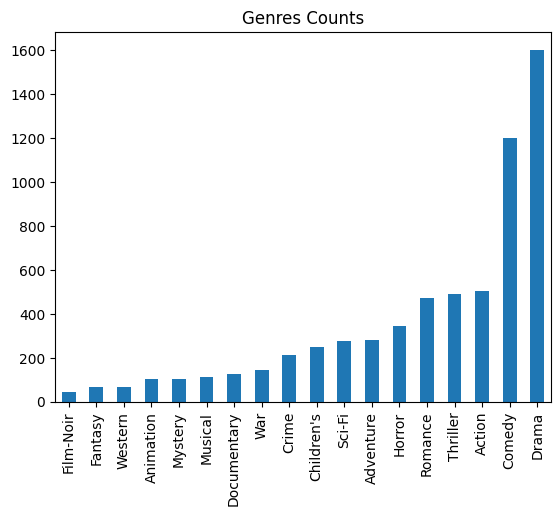

In [8]:
genre_total.plot(kind='bar',title='Genres Counts')

In [9]:
mov_rat = movies_cleaned.merge(ratings, on='MovieID')

In [10]:
mov_rat.head(2)

,MovieID,Title,Title_1,Production_Year,Decade,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,UserID,Rating,Timestamp
0,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,1,5,978824268
1,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,6,4,978237008


<AxesSubplot: >

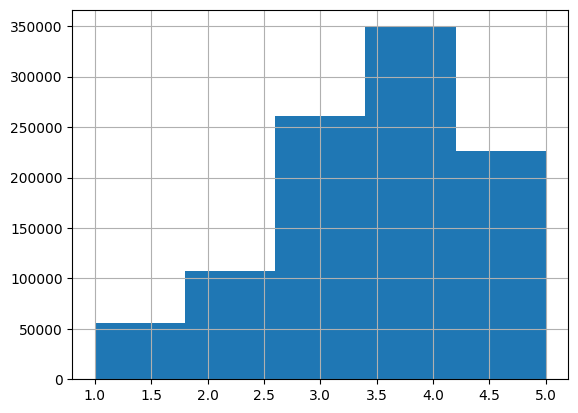

In [11]:
mov_rat['Rating'].hist(bins=5)

## Recommender 1: Method 1-
### Let's Find the top movies by Genre

In [17]:
GENRE_FOR_RECOMMENDATION='Adventure'

In [18]:
mov_rat_adv = mov_rat[(mov_rat[GENRE_FOR_RECOMMENDATION]==1)]
mov_rat_adv.reset_index(drop=True,inplace=True)
genre_grouped= mov_rat_adv[['MovieID','Title_1','Rating']].groupby(['MovieID','Title_1','Rating']).size()
genre_grouped_df = genre_grouped.to_frame('count').reset_index()
genre_rating = genre_grouped_df.pivot(index=['MovieID','Title_1'],columns='Rating',values='count').fillna(0)
genre_rating.columns=['r1','r2','r3','r4','r5']
def moviescore(r):
    return r.r1*(-1)+r.r2*(-0.5)+r.r3*(-0.1)+r.r4*(0.5)+r.r5
genre_rating['score']=genre_rating.apply(moviescore,axis=1)

## Top 5 Movies in dataset

In [19]:
genre_rating.score.nlargest(n=5)

MovieID  Title_1                                       
260      Star Wars: Episode IV - A New Hope                2145.2
1196     Star Wars: Episode V - The Empire Strikes Back    1895.5
1198     Raiders of the Lost Ark                           1836.2
1197     Princess Bride, The                               1478.2
1210     Star Wars: Episode VI - Return of the Jedi        1415.6
Name: score, dtype: float64

genre_rating